# PySpark Cookbook

### Tomasz Drabas, Denny Lee
#### Version: 0.1
#### Date: 1/15/2018

# Some data

In [1]:
dirty_data = spark.createDataFrame([
          (1,'Porsche','Boxster S','Turbo',2.5,4,22,None)
        , (2,'Aston Martin','Vanquish','Aspirated',6.0,12,16,None)
        , (3,'Porsche','911 Carrera 4S Cabriolet','Turbo',3.0,6,24,None)
        , (3,'General Motors','SPARK ACTIV','Aspirated',1.4,None,32,None)
        , (5,'BMW','COOPER S HARDTOP 2 DOOR','Turbo',2.0,4,26,None)
        , (6,'BMW','330i','Turbo',2.0,None,27,None)
        , (7,'BMW','440i Coupe','Turbo',3.0,6,23,None)
        , (8,'BMW','440i Coupe','Turbo',3.0,6,23,None)
        , (9,'Mercedes-Benz',None,None,None,None,27,None)
        , (10,'Mercedes-Benz','CLS 550','Turbo',4.7,8,21,79231)
        , (11,'Volkswagen','GTI','Turbo',2.0,4,None,None)
        , (12,'Ford Motor Company','FUSION AWD','Turbo',2.7,6,20,None)
        , (13,'Nissan','Q50 AWD RED SPORT','Turbo',3.0,6,22,None)
        , (14,'Nissan','Q70 AWD','Aspirated',5.6,8,18,None)
        , (15,'Kia','Stinger RWD','Turbo',2.0,4,25,None)
        , (16,'Toyota','CAMRY HYBRID LE','Aspirated',2.5,4,46,None)
        , (16,'Toyota','CAMRY HYBRID LE','Aspirated',2.5,4,46,None)
        , (18,'FCA US LLC','300','Aspirated',3.6,6,23,None)
        , (19,'Hyundai','G80 AWD','Turbo',3.3,6,20,None)
        , (20,'Hyundai','G80 AWD','Turbo',3.3,6,20,None)
        , (21,'BMW','X5 M','Turbo',4.4,8,18,121231)
        , (22,'GE','K1500 SUBURBAN 4WD','Aspirated',5.3,8,18,None)
    ], ['Id','Manufacturer','Model','EngineType','Displacement',
        'Cylinders','FuelEconomy','MSRP'])

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,None,pyspark3,idle,,,✔


SparkSession available as 'spark'.


# Handling duplicates

### Exact duplicates

In [2]:
# do we have any rows that are duplicated?
dirty_data.count(), dirty_data.distinct().count()

(22, 21)

In [3]:
# what row is duplicated?
(
    dirty_data
    .groupby(dirty_data.columns)
    .count()
    .filter('count > 1')
    .show()
)

+---+------------+---------------+----------+------------+---------+-----------+----+-----+
| Id|Manufacturer|          Model|EngineType|Displacement|Cylinders|FuelEconomy|MSRP|count|
+---+------------+---------------+----------+------------+---------+-----------+----+-----+
| 16|      Toyota|CAMRY HYBRID LE| Aspirated|         2.5|        4|         46|null|    2|
+---+------------+---------------+----------+------------+---------+-----------+----+-----+

In [4]:
# remove the duplicated rows
full_removed = dirty_data.dropDuplicates()
full_removed.count()

21

### Only ID differs

In [5]:
# count of rows
no_ids = (
    full_removed
    .select([col for col in full_removed.columns if col != 'Id'])
)

no_ids.count(), no_ids.distinct().count()

(21, 19)

In [6]:
# what row is duplicated?
(
    full_removed
    .groupby([col for col in full_removed.columns if col != 'Id'])
    .count()
    .filter('count > 1')
    .show()
)

+------------+----------+----------+------------+---------+-----------+----+-----+
|Manufacturer|     Model|EngineType|Displacement|Cylinders|FuelEconomy|MSRP|count|
+------------+----------+----------+------------+---------+-----------+----+-----+
|         BMW|440i Coupe|     Turbo|         3.0|        6|         23|null|    2|
|     Hyundai|   G80 AWD|     Turbo|         3.3|        6|         20|null|    2|
+------------+----------+----------+------------+---------+-----------+----+-----+

In [7]:
# remove the duplicated record
id_removed = full_removed.dropDuplicates(
    subset = [col for col in full_removed.columns if col != 'Id']
)

In [8]:
# count
id_removed.count()

19

### Duplicated IDs

In [9]:
# are there any duplicated IDs?
import pyspark.sql.functions as fn

id_removed.agg(
      fn.count('Id').alias('CountOfIDs')
    , fn.countDistinct('Id').alias('CountOfDistinctIDs')
).show()

+----------+------------------+
|CountOfIDs|CountOfDistinctIDs|
+----------+------------------+
|        19|                18|
+----------+------------------+

In [10]:
# what's duplicated?
(
    id_removed
    .groupby('Id')
    .count()
    .filter('count > 1')
    .show()
)

+---+-----+
| Id|count|
+---+-----+
|  3|    2|
+---+-----+

In [11]:
(
    id_removed
    .filter('Id = 3')
    .show()
)

+---+--------------+--------------------+----------+------------+---------+-----------+----+
| Id|  Manufacturer|               Model|EngineType|Displacement|Cylinders|FuelEconomy|MSRP|
+---+--------------+--------------------+----------+------------+---------+-----------+----+
|  3|General Motors|         SPARK ACTIV| Aspirated|         1.4|     null|         32|null|
|  3|       Porsche|911 Carrera 4S Ca...|     Turbo|         3.0|        6|         24|null|
+---+--------------+--------------------+----------+------------+---------+-----------+----+

In [12]:
new_id = (
    id_removed
    .select(
        [fn.monotonically_increasing_id().alias('Id')] + 
        [col for col in id_removed.columns if col != 'Id'])
)

new_id.show()

+-------------+------------------+--------------------+----------+------------+---------+-----------+------+
|           Id|      Manufacturer|               Model|EngineType|Displacement|Cylinders|FuelEconomy|  MSRP|
+-------------+------------------+--------------------+----------+------------+---------+-----------+------+
|   8589934592|    General Motors|         SPARK ACTIV| Aspirated|         1.4|     null|         32|  null|
| 188978561024|     Mercedes-Benz|             CLS 550|     Turbo|         4.7|        8|         21| 79231|
| 197568495616|     Mercedes-Benz|                null|      null|        null|     null|         27|  null|
| 206158430208|Ford Motor Company|          FUSION AWD|     Turbo|         2.7|        6|         20|  null|
| 438086664192|               BMW|COOPER S HARDTOP ...|     Turbo|         2.0|        4|         26|  null|
| 523986010112|      Aston Martin|            Vanquish| Aspirated|         6.0|       12|         16|  null|
| 721554505728|    

# Handling missing observations

### Missing observations per row

In [13]:
(
    spark.createDataFrame(
        new_id.rdd.map(
           lambda row: (
                 row['Id']
               , sum([c == None for c in row])
           )
        )
        .filter(lambda el: el[1] > 1)
        .collect()
        ,['Id', 'CountMissing']
    )
    .orderBy('CountMissing', ascending=False)
    .show()
)

+------------+------------+
|          Id|CountMissing|
+------------+------------+
|197568495616|           5|
|  8589934592|           2|
|919123001344|           2|
|721554505728|           2|
+------------+------------+

In [14]:
(
    new_id
    .where('Id == 197568495616')
    .show()
)

+------------+-------------+-----+----------+------------+---------+-----------+----+
|          Id| Manufacturer|Model|EngineType|Displacement|Cylinders|FuelEconomy|MSRP|
+------------+-------------+-----+----------+------------+---------+-----------+----+
|197568495616|Mercedes-Benz| null|      null|        null|     null|         27|null|
+------------+-------------+-----+----------+------------+---------+-----------+----+

In [15]:
merc_out = new_id.dropna(thresh=4)
new_id.count(), merc_out.count()

(19, 18)

In [16]:
(
    merc_out
    .where('Id == 197568495616')
    .show()
)

+---+------------+-----+----------+------------+---------+-----------+----+
| Id|Manufacturer|Model|EngineType|Displacement|Cylinders|FuelEconomy|MSRP|
+---+------------+-----+----------+------------+---------+-----------+----+
+---+------------+-----+----------+------------+---------+-----------+----+

### Missing observations per column

In [17]:
for k, v in sorted(
    merc_out.agg(*[
               (1 - (fn.count(c) / fn.count('*')))
                    .alias(c + '_miss')
               for c in merc_out.columns
           ])
        .collect()[0]
        .asDict()
        .items()
    , key=lambda el: el[1]
    , reverse=True
):
    print(k, v)

MSRP_miss 0.8888888888888888
Cylinders_miss 0.11111111111111116
FuelEconomy_miss 0.05555555555555558
Id_miss 0.0
Manufacturer_miss 0.0
Model_miss 0.0
EngineType_miss 0.0
Displacement_miss 0.0

In [18]:
no_MSRP = merc_out.select([col for col in new_id.columns if col != 'MSRP'])
no_MSRP.show()

+-------------+------------------+--------------------+----------+------------+---------+-----------+
|           Id|      Manufacturer|               Model|EngineType|Displacement|Cylinders|FuelEconomy|
+-------------+------------------+--------------------+----------+------------+---------+-----------+
|   8589934592|    General Motors|         SPARK ACTIV| Aspirated|         1.4|     null|         32|
| 188978561024|     Mercedes-Benz|             CLS 550|     Turbo|         4.7|        8|         21|
| 206158430208|Ford Motor Company|          FUSION AWD|     Turbo|         2.7|        6|         20|
| 438086664192|               BMW|COOPER S HARDTOP ...|     Turbo|         2.0|        4|         26|
| 523986010112|      Aston Martin|            Vanquish| Aspirated|         6.0|       12|         16|
| 721554505728|        Volkswagen|                 GTI|     Turbo|         2.0|        4|       null|
| 764504178688|               Kia|         Stinger RWD|     Turbo|         2.0|   

### Sparse missing observations

In [19]:
multipliers = (
    no_MSRP
    .agg(
          fn.mean(
              fn.col('FuelEconomy') / 
              (
                  fn.col('Displacement') * fn.col('Cylinders')
              )
          ).alias('FuelEconomy')
        , fn.mean(
            fn.col('Cylinders') / 
            fn.col('Displacement')
        ).alias('Cylinders')
    )
).toPandas().to_dict('records')[0]

multipliers

{'FuelEconomy': 1.4957485048359973, 'Cylinders': 1.8353365984789105}

In [20]:
imputed = (
    no_MSRP
    .withColumn('FuelEconomy', fn.col('FuelEconomy')   / fn.col('Displacement') / fn.col('Cylinders'))
    .withColumn('Cylinders',   fn.col('Cylinders')   / fn.col('Displacement'))
    .fillna(multipliers)
    .withColumn('Cylinders',   (fn.col('Cylinders')   * fn.col('Displacement')).cast('integer'))
    .withColumn('FuelEconomy', fn.col('FuelEconomy') * fn.col('Displacement') * fn.col('Cylinders'))
)

imputed.show()

+-------------+------------------+--------------------+----------+------------+---------+------------------+
|           Id|      Manufacturer|               Model|EngineType|Displacement|Cylinders|       FuelEconomy|
+-------------+------------------+--------------------+----------+------------+---------+------------------+
|   8589934592|    General Motors|         SPARK ACTIV| Aspirated|         1.4|        2| 4.188095813540793|
| 188978561024|     Mercedes-Benz|             CLS 550|     Turbo|         4.7|        8|              21.0|
| 206158430208|Ford Motor Company|          FUSION AWD|     Turbo|         2.7|        5|16.666666666666668|
| 438086664192|               BMW|COOPER S HARDTOP ...|     Turbo|         2.0|        4|              26.0|
| 523986010112|      Aston Martin|            Vanquish| Aspirated|         6.0|       12|              16.0|
| 721554505728|        Volkswagen|                 GTI|     Turbo|         2.0|        4|11.965988038687978|
| 764504178688|    

# Handling outliers

In [21]:
features = ['Displacement', 'Cylinders', 'FuelEconomy']
quantiles = [0.25, 0.75]

cut_off_points = []

for feature in features:
    quants = imputed.approxQuantile(feature, quantiles, 0.05)
    
    IQR = quants[1] - quants[0]
    cut_off_points.append((feature, [
        quants[0] - 1.5 * IQR,
        quants[1] + 1.5 * IQR,
    ]))
    
cut_off_points = dict(cut_off_points)

outliers = imputed.select(*['id'] + [
       (
           (imputed[f] < cut_off_points[f][0]) |
           (imputed[f] > cut_off_points[f][1])
       ).alias(f + '_o') for f in features
  ])
outliers.show()

+-------------+--------------+-----------+-------------+
|           id|Displacement_o|Cylinders_o|FuelEconomy_o|
+-------------+--------------+-----------+-------------+
|   8589934592|         false|      false|         true|
| 188978561024|         false|      false|        false|
| 206158430208|         false|      false|        false|
| 438086664192|         false|      false|        false|
| 523986010112|         false|      false|        false|
| 721554505728|         false|      false|        false|
| 764504178688|         false|      false|        false|
| 919123001344|         false|      false|        false|
| 944892805120|         false|      false|        false|
| 970662608896|         false|      false|        false|
|1030792151040|         false|      false|        false|
|1039382085632|         false|      false|        false|
|1116691496960|         false|      false|        false|
|1211180777472|         false|      false|        false|
|1331439861760|         false| 

In [22]:
with_outliers_flag = imputed.join(outliers, on='Id')

(
    with_outliers_flag
    .filter('FuelEconomy_o')
    .select('Id', 'Manufacturer', 'Model', 'FuelEconomy')
    .show()
)

+-------------+--------------+---------------+-----------------+
|           Id|  Manufacturer|          Model|      FuelEconomy|
+-------------+--------------+---------------+-----------------+
|   8589934592|General Motors|    SPARK ACTIV|4.188095813540793|
|1614907703296|        Toyota|CAMRY HYBRID LE|             46.0|
+-------------+--------------+---------------+-----------------+

In [23]:
no_outliers = (
    with_outliers_flag
    .filter('!FuelEconomy_o')
    .select(imputed.columns)
)

# Exploring descriptive statistics

In [24]:
descriptive_stats = no_outliers.describe(features)
descriptive_stats.show()

+-------+-----------------+-----------------+------------------+
|summary|     Displacement|        Cylinders|       FuelEconomy|
+-------+-----------------+-----------------+------------------+
|  count|               16|               16|                16|
|   mean|          3.44375|            6.125|19.600446608398165|
| stddev|1.354975399530683|2.276693508870558| 4.666647767373751|
|    min|              2.0|                3| 8.974491029015983|
|    max|              6.0|               12|              26.0|
+-------+-----------------+-----------------+------------------+

In [25]:
descriptive_stats_all = no_outliers.describe()
descriptive_stats_all.show()

+-------+--------------------+------------+-----+----------+-----------------+-----------------+------------------+
|summary|                  Id|Manufacturer|Model|EngineType|     Displacement|        Cylinders|       FuelEconomy|
+-------+--------------------+------------+-----+----------+-----------------+-----------------+------------------+
|  count|                  16|          16|   16|        16|               16|               16|                16|
|   mean|    9.19659872256E11|        null|300.0|      null|          3.44375|            6.125|19.600446608398165|
| stddev|4.396778949583304E11|        null|  NaN|      null|1.354975399530683|2.276693508870558| 4.666647767373751|
|    min|        188978561024|Aston Martin|  300| Aspirated|              2.0|                3| 8.974491029015983|
|    max|       1700807049216|  Volkswagen| X5 M|     Turbo|              6.0|               12|              26.0|
+-------+--------------------+------------+-----+----------+------------

In [26]:
(
    no_outliers
    .select(features)
    .groupBy('Cylinders')
    .agg(*[
          fn.count('*').alias('Count')
        , fn.mean('FuelEconomy').alias('MPG_avg')
        , fn.mean('Displacement').alias('Disp_avg')
        , fn.stddev('FuelEconomy').alias('MPG_stdev')
        , fn.stddev('Displacement').alias('Disp_stdev')
    ])
    .orderBy('Cylinders')
).show()

+---------+-----+------------------+------------------+------------------+-------------------+
|Cylinders|Count|           MPG_avg|          Disp_avg|         MPG_stdev|         Disp_stdev|
+---------+-----+------------------+------------------+------------------+-------------------+
|        3|    1| 8.974491029015983|               2.0|               NaN|                NaN|
|        4|    4|21.241497009671995|             2.125| 6.413009924998989|0.24999999999999994|
|        5|    1|16.666666666666668|               2.7|               NaN|                NaN|
|        6|    5|              22.4|3.1799999999999997|1.5165750888103104|0.26832815729997467|
|        8|    4|             18.75|               5.0|               1.5| 0.5477225575051655|
|       12|    1|              16.0|               6.0|               NaN|                NaN|
+---------+-----+------------------+------------------+------------------+-------------------+

# Computing correlations

In [27]:
(
    no_outliers
    .corr('Cylinders', 'Displacement')
)

0.9381829964408109

In [28]:
n_features = len(features)

corr = []

for i in range(0, n_features):
    temp = [None] * i

    for j in range(i, n_features):
        temp.append(no_outliers.corr(features[i], features[j]))
    corr.append([features[i]] + temp)

correlations = spark.createDataFrame(corr, ['Column'] + features)

correlations.show()

+------------+------------+------------------+--------------------+
|      Column|Displacement|         Cylinders|         FuelEconomy|
+------------+------------+------------------+--------------------+
|Displacement|         1.0|0.9381829964408109|-0.10757908872387652|
|   Cylinders|        null|               1.0|-0.04218546545035314|
| FuelEconomy|        null|              null|                 1.0|
+------------+------------+------------------+--------------------+

# Drawing histograms

In [29]:
histogram_MPG = (
    no_outliers
    .select('FuelEconomy')
    .rdd
    .flatMap(lambda record: record)
    .histogram(5)
)

In [30]:
for i in histogram_MPG:
    print(i)
    
histogram_MPG

[8.974491029015983, 12.379592823212786, 15.78469461740959, 19.189796411606395, 22.594898205803197, 26.0]
[2, 0, 5, 4, 5]
([8.974491029015983, 12.379592823212786, 15.78469461740959, 19.189796411606395, 22.594898205803197, 26.0], [2, 0, 5, 4, 5])

In [31]:
for i in range(len(histogram_MPG[0])-1):
    print('[' + str(round(histogram_MPG[0][i],2))
        + ',' + str(round(histogram_MPG[0][i+1],2))
          + ')'
         )

[8.97,12.38)
[12.38,15.78)
[15.78,19.19)
[19.19,22.59)
[22.59,26.0)

In [32]:
(
    spark
    .createDataFrame(
        [(bins, counts) 
         for bins, counts 
         in zip(
             histogram_MPG[0], 
             histogram_MPG[1]
         )]
        , ['bins', 'counts']
    )
    .registerTempTable('histogram_MPG')
)

In [33]:
%%sql -o hist_MPG -q
SELECT * FROM histogram_MPG

Text(0.5,1,'Histogram of fuel economy')

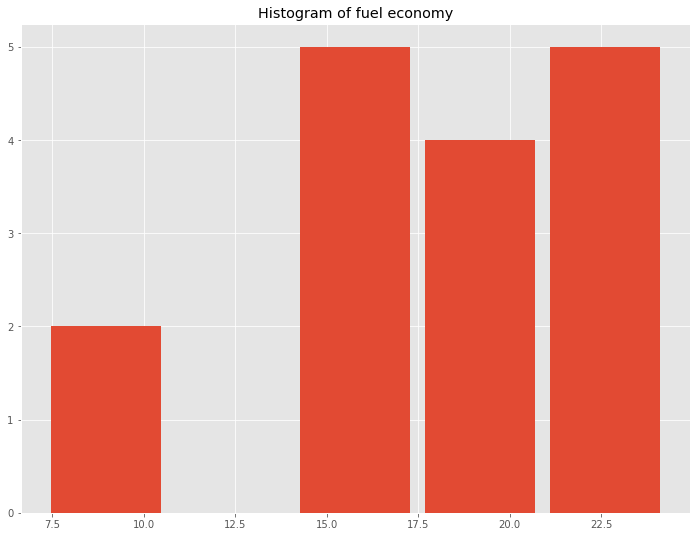

In [34]:
%%local
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(1, 1, 1)
ax.bar(hist_MPG['bins'], hist_MPG['counts'], width=3)
ax.set_title('Histogram of fuel economy')

In [35]:
%%local
from bokeh.io import show
from bokeh.plotting import figure
from bokeh.io import output_notebook
output_notebook()

labels = [str(round(e, 2)) for e in hist_MPG['bins']]

p = figure(
    x_range=labels, 
    plot_height=350, 
    title='Histogram of fuel economy'
)

p.vbar(x=labels, top=hist_MPG['counts'], width=0.9)

show(p)

Loading BokehJS ...

# Visualizing interactions between features

In [36]:
scatter = (
    no_outliers
    .select('Displacement', 'Cylinders')
)

scatter.registerTempTable('scatter')

In [37]:
%%sql -o scatter_source -q
SELECT * FROM scatter

Text(0.5,1,'Relationship between cylinders and displacement')

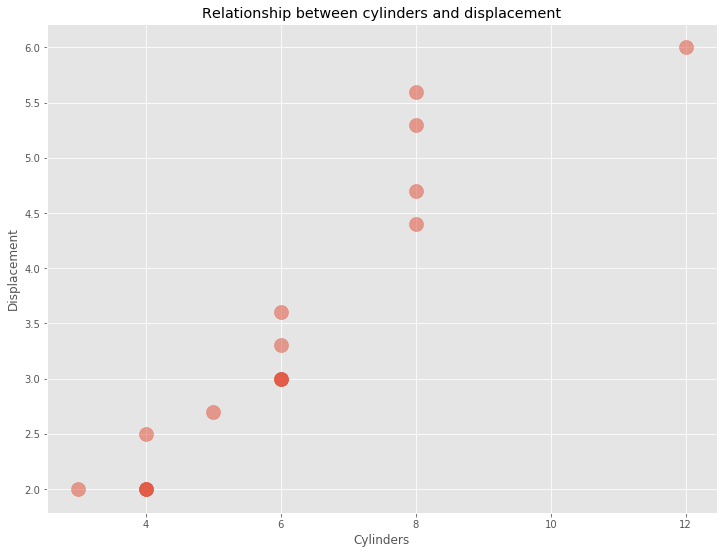

In [38]:
%%local
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(
      list(scatter_source['Cylinders'])
    , list(scatter_source['Displacement'])
    , s = 200
    , alpha = 0.5
)

ax.set_xlabel('Cylinders')
ax.set_ylabel('Displacement')

ax.set_title('Relationship between cylinders and displacement')

In [39]:
%%local 
from bokeh.io import show
from bokeh.plotting import figure
from bokeh.io import output_notebook
output_notebook()
p = figure(title = 'Relationship between cylinders and displacement')
p.xaxis.axis_label = 'Cylinders'
p.yaxis.axis_label = 'Displacement'

p.circle(  list(scatter_source['Cylinders'])
         , list(scatter_source['Displacement'])
         , fill_alpha=0.2, size=10)

show(p)

Loading BokehJS ...